Here we should make sure that Transformer model is Ok to be used as a denoising autoencoder

In [3]:
import sys; sys.path += ['..', '../src']

In [4]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.de.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.de.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

train_src = [s.split() for s in train_src]
train_trg = [s.split() for s in train_trg]
val_src = [s.split() for s in val_src]
val_trg = [s.split() for s in val_trg]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.de'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]

In [5]:
import tqdm

from src.transformer.models import Transformer

max_len = 50

model = Transformer(
    len(vocab_src),
    len(vocab_trg),
    max_len,
    n_layers=4,
    n_head=4,
    d_word_vec=512,
    d_model=512,
    d_inner_hid=1024,
    d_k=64,
    d_v=64)

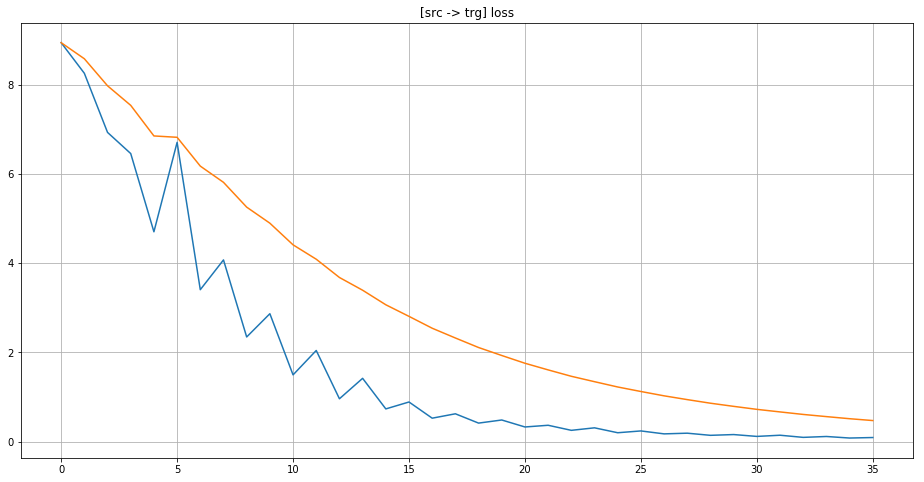

KeyboardInterrupt: 

In [7]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
tqdm.monitor_interval = 0

from src.utils.umt_batcher import UMTBatcher
import src.transformer.constants as constants


def get_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)


optimizer = Adam(model.get_trainable_parameters())
criterion = get_criterion(len(vocab_src))
training_data = UMTBatcher(train_src_idx[:8], train_trg_idx[:8], vocab_src, vocab_trg, batch_size=4)

model.train()
loss_history = []
num_iters_done = 0
max_num_epochs = 100

for i in range(max_num_epochs):
    for batch in tqdm(training_data, leave=False):
        # prepare data
        src_noised, trg_noised, src, trg = batch

        # forward
        optimizer.zero_grad()
        preds = model(src_noised, src, use_src_embs_in_decoder=True)

        # backward
        loss = criterion(preds, src[:, 1:].contiguous().view(-1))
        
        loss.backward()

        # update parameters
        optimizer.step()

        loss_history.append(loss.data[0])
        num_iters_done += 1

        if num_iters_done % 2 == 0:
            clear_output(True)
            plt.figure(figsize=[16,8])
            plt.title("[src -> trg] loss")
            plt.plot(loss_history)
            plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=20).mean())
            plt.grid()
            plt.show()

In [9]:
batch = next(training_data)

In [10]:
translations = model.translate_batch(batch[0], max_len=20, beam_size=2, use_src_embs_in_decoder=True)
translations = np.array(translations)

100%|██████████| 20/20 [00:01<00:00, 11.51it/s]


In [15]:
for i in range(len(translations)):
    print('Input     :', vocab_src.remove_bpe(vocab_src.detokenize(batch[0].data[i])))
    print('Translated:', vocab_src.remove_bpe(vocab_src.detokenize(translations[i])))
    print('Real      :', vocab_src.remove_bpe(vocab_src.detokenize(batch[2].data[i])))
    print()

Input     : young Two , males White outside are bushes many near . __PAD__ __PAD__
Translated: men are at the stove preparing food . . . . . . . . . . . . .
Real      : Two young , White males are outside near many bushes . __PAD__ __PAD__ __PAD__ __PAD__

Input     : hard in men Several operating are hats giant a ley pul. __PAD__
Translated: men in hard hats are operating a giant pulley system . . . . . . . . .
Real      : Several men in hard hats are operating a giant pulley system . __PAD__ __PAD__

Input     : little girl into climbing . wooden house a __PAD__ __PAD__ __PAD__ __PAD__ __PAD__
Translated: men are at the stove preparing food . . . . . . . . . . . . .
Real      : A little girl climbing into a wooden playhouse . __PAD__ __PAD__ __PAD__ __PAD__ __PAD__

Input     : blue a in man standing is shirt a on ladder cleaning a window
Translated: men in hard hats are operating a giant pulley system . . . . . . . . .
Real      : A man in a blue shirt is standing on a ladder cleani